<h1 style="text-align:center;">Modelling for S&P 500</h1>

### Model Training 

In [105]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
import numpy as np
import time

# Load the data
df = pd.read_csv('/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/Datasets/dataframe_cleaned.csv')

#Time-Series set the Data
import time
if isinstance(df.index, pd.DatetimeIndex):
    print("Time Series has been set")
else:
    print("Time Series has not been set yet")
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.set_index('Date', inplace=True)
    time.sleep(3)
    print("It has been done now!")

#Split the data into training and testing
size = int(len(df)*0.7)
df, df_test = df.iloc[:size], df.iloc[size:]

#Normalised Prices
df_norm = df/df.iloc[0]*100 #Create a new variable incase we want to visualise/test/forecast with the original data
df_norm_test = df_test/df.iloc[0]*100

#Log Returns 
df_log = np.log(df / df.shift(1))
df_log_test = np.log(df_test / df_test.shift(1))

#Creating LLR Test (defining the function)
from scipy.stats import chi2
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

Time Series has not been set yet
It has been done now!


### Testing for Stationarity

Text(0.5, 1.0, 'S&P 500 Prices')

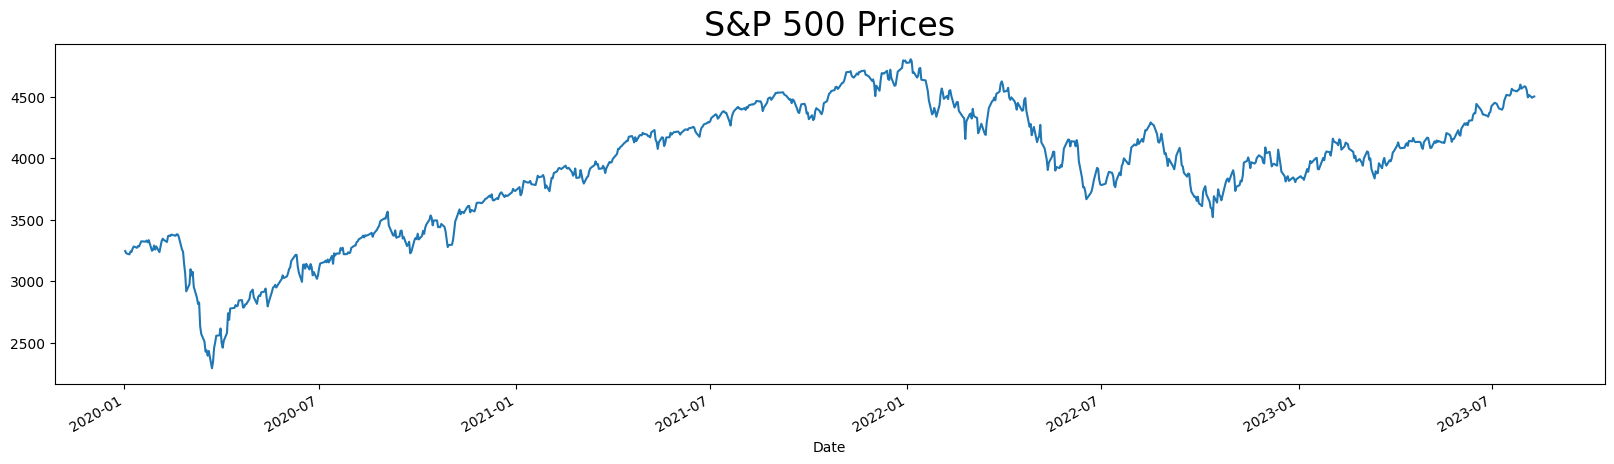

In [13]:
df.SPX.plot(figsize=(20,5))
plt.title("S&P 500 Prices", size=24) 

In [36]:
#Dickey-Fuller Test
import statsmodels.tsa.stattools as sts
adf_result1 = sts.adfuller(df.SPX)

adf_result1

(np.float64(-1.4420573341139522),
 np.float64(0.5619556138515125),
 1,
 902,
 {'1%': np.float64(-3.437620518167552),
  '5%': np.float64(-2.8647495822909477),
  '10%': np.float64(-2.568478995776815)},
 np.float64(9215.472273205383))

In [60]:
print(f'We find the p-value = {adf_result1[1]}')
#Since the p-value is greater than 0.05, we cannot reject H0, and therefore SPX is not stationary in levels form

We find the p-value = 0.5619556138515125


In [108]:
df['SPX(i1)'] = df.SPX.diff(1)
df= df.dropna()
df.head()

,SPX,NDAQ,AAPL,MSFT,NFLX,NVDA,SPX(i1)
Date,,,,,,,
2020-01-03,3226.360107,33.176522,71.941343,151.127748,326.779999,5.852962,-18.309815
2020-01-06,3217.550049,33.427723,71.127858,149.944070,323.119995,5.783753,-8.810058
2020-01-07,3241.860107,33.492839,72.592594,152.082331,336.470001,5.930140,24.310058
2020-01-08,3238.590088,33.030765,71.943766,151.710031,331.489990,5.968977,-3.270019
2020-01-09,3266.030029,32.956335,74.384158,154.487843,342.000000,6.070800,27.439941


In [109]:
import statsmodels.tsa.stattools as sts
adf_result2 = sts.adfuller(df['SPX(i1)'])
print(f'We find the p-value = {adf_result2[1]}')
#Since the p-value is less than 0.05, we can reject H0, and therefore SPX is stationary in first-diff (I=1) form

We find the p-value = 0.0


### Identifying optimal AR(p) lag

(-0.15, 0.15)

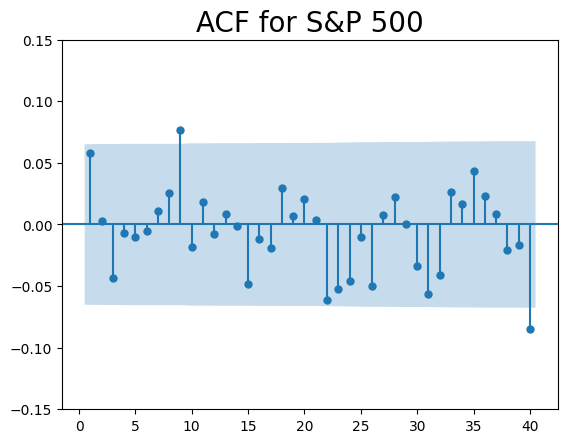

In [63]:
price_acf = sgt.plot_acf(df['SPX(i1)'], zero = False, lags = 40)
plt.title("ACF for S&P 500", size = 20)
plt.ylim(-0.15,0.15)

(-0.15, 0.15)

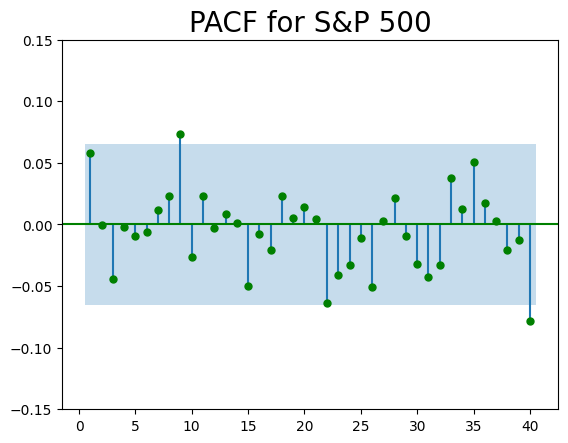

In [64]:
#Since our ACF didn't show many significant lags, we can use the pacf to check if a few specific lags have a strong direct effect
price_pacf = sgt.plot_pacf(df['SPX(i1)'], zero = False, lags = 40, color = "green")
plt.title("PACF for S&P 500", size = 20)
plt.ylim(-0.15,0.15) 
#Again, we find similar results to the ACF: the lowest lag that is most significant (hence optimal) is the 9th lag.

### Comparing models to determine if AR(9) is the best fit

In [ ]:
ar_1 = ARIMA(df['SPX(i1)'], order=(1,0,0))
results_ar_1 = ar_1.fit()
print(results_ar_1.summary()) 

                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4724.223
Date:                Wed, 12 Mar 2025   AIC                           9454.445
Time:                        22:43:10   BIC                           9468.872
Sample:                             0   HQIC                          9459.955
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3873      1.623      0.855      0.393      -1.793       4.568
ar.L1          0.0577      0.028      2.096      0.036       0.004       0.112
sigma2      1981.7871     71.002     27.912      0.0

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [69]:
ar_2 = ARIMA(df['SPX(i1)'], order=(2,0,0))
results_ar_2 = ar_2.fit()
print(results_ar_2.summary())

                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -4724.223
Date:                Wed, 12 Mar 2025   AIC                           9456.446
Time:                        22:45:23   BIC                           9475.683
Sample:                             0   HQIC                          9463.792
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3873      1.638      0.847      0.397      -1.824       4.599
ar.L1          0.0577      0.028      2.095      0.036       0.004       0.112
ar.L2         -0.0005      0.028     -0.018      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [110]:
print(f"p-value = {LLR_test(ar_1, ar_2)}")

p-value = 1.0


In [ ]:
#Looking at all AR(p) models from 3 to 9
ar_3 = ARIMA(df['SPX(i1)'], order=(3,0,0))
results_ar_3 = ar_3.fit()
print(results_ar_3.summary()) 

ar_4 = ARIMA(df['SPX(i1)'], order=(4,0,0))
results_ar_4 = ar_4.fit()
print(results_ar_4.summary()) 

ar_5 = ARIMA(df['SPX(i1)'], order=(5,0,0))
results_ar_5 = ar_5.fit()
print(results_ar_5.summary()) 

ar_6 = ARIMA(df['SPX(i1)'], order=(6,0,0))
results_ar_6 = ar_6.fit()
print(results_ar_6.summary()) 

ar_7 = ARIMA(df['SPX(i1)'], order=(7,0,0))
results_ar_7 = ar_7.fit()
print(results_ar_7.summary()) 

ar_8 = ARIMA(df['SPX(i1)'], order=(8,0,0))
results_ar_8 = ar_8.fit()
print(results_ar_8.summary()) 

ar_9 = ARIMA(df['SPX(i1)'], order=(9,0,0))
results_ar_9 = ar_9.fit()
print(results_ar_9.summary()) 

#Additional lag to ensure 9th lag is the most optimal
ar_10 = ARIMA(df['SPX(i1)'], order=(10,0,0))
results_ar_10 = ar_10.fit()
print(results_ar_10.summary()) 

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python

                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -4723.346
Date:                Wed, 12 Mar 2025   AIC                           9456.693
Time:                        23:27:07   BIC                           9480.738
Sample:                             0   HQIC                          9465.875
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3873      1.582      0.877      0.380      -1.713       4.488
ar.L1          0.0577      0.028      2.082      0.037       0.003       0.112
ar.L2          0.0020      0.028      0.073      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -4723.284
Date:                Wed, 12 Mar 2025   AIC                           9462.568
Time:                        23:27:08   BIC                           9501.040
Sample:                             0   HQIC                          9477.260
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3877      1.618      0.858      0.391      -1.783       4.558
ar.L1          0.0575      0.028      2.057      0.040       0.003       0.112
ar.L2          0.0016      0.028      0.058      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -4723.224
Date:                Wed, 12 Mar 2025   AIC                           9464.448
Time:                        23:27:09   BIC                           9507.729
Sample:                             0   HQIC                          9480.976
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3872      1.641      0.845      0.398      -1.829       4.604
ar.L1          0.0576      0.028      2.052      0.040       0.003       0.113
ar.L2          0.0017      0.028      0.061      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -4722.976
Date:                Wed, 12 Mar 2025   AIC                           9465.953
Time:                        23:27:10   BIC                           9514.043
Sample:                             0   HQIC                          9484.318
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3867      1.682      0.824      0.410      -1.911       4.684
ar.L1          0.0573      0.028      2.042      0.041       0.002       0.112
ar.L2          0.0019      0.028      0.067      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -4720.529
Date:                Wed, 12 Mar 2025   AIC                           9463.057
Time:                        23:27:11   BIC                           9515.957
Sample:                             0   HQIC                          9483.259
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3836      1.815      0.762      0.446      -2.174       4.942
ar.L1          0.0556      0.028      2.018      0.044       0.002       0.110
ar.L2          0.0011      0.028      0.040      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                ARIMA(10, 0, 0)   Log Likelihood               -4720.220
Date:                Wed, 12 Mar 2025   AIC                           9464.440
Time:                        23:27:12   BIC                           9522.148
Sample:                             0   HQIC                          9486.478
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3839      1.771      0.781      0.435      -2.087       4.855
ar.L1          0.0575      0.028      2.083      0.037       0.003       0.112
ar.L2          0.0016      0.028      0.057      0.9

In [138]:
#LLR Test for the above AR models
print(f"p-value = {LLR_test(ar_1, ar_2)}")
print(f"p-value = {LLR_test(ar_2, ar_3)}")
print(f"p-value = {LLR_test(ar_3, ar_4)}")
print(f"p-value = {LLR_test(ar_4, ar_5)}")
print(f"p-value = {LLR_test(ar_5, ar_6)}")
print(f"p-value = {LLR_test(ar_6, ar_7)}")
print(f"p-value = {LLR_test(ar_7, ar_8)}")
print(f"p-value = {LLR_test(ar_8, ar_9)}")
print(f"p-value = {LLR_test(ar_9, ar_10)}")

p-value = 1.0
p-value = 0.185
p-value = 0.974
p-value = 0.761
p-value = 0.858
p-value = 0.729
p-value = 0.482
p-value = 0.027
p-value = 0.432


In [139]:
#We should also look at the their AIC and BIC values and see if 9 is the optimal number of lags
print(f"AR(1) AIC: {results_ar_1.aic}, BIC: {results_ar_1.bic}")
print(f"AR(2) AIC: {results_ar_2.aic}, BIC: {results_ar_2.bic}")   
print(f"AR(3) AIC: {results_ar_3.aic}, BIC: {results_ar_3.bic}")
print(f"AR(4) AIC: {results_ar_4.aic}, BIC: {results_ar_4.bic}")
print(f"AR(5) AIC: {results_ar_5.aic}, BIC: {results_ar_5.bic}")
print(f"AR(6) AIC: {results_ar_6.aic}, BIC: {results_ar_6.bic}")
print(f"AR(7) AIC: {results_ar_7.aic}, BIC: {results_ar_7.bic}")
print(f"AR(8) AIC: {results_ar_8.aic}, BIC: {results_ar_8.bic}")
print(f"AR(9) AIC: {results_ar_9.aic}, BIC: {results_ar_9.bic}")
print(f"AR(10) AIC: {results_ar_10.aic}, BIC: {results_ar_10.bic}")

AR(1) AIC: 9454.44529893487, BIC: 9468.872416852999
AR(2) AIC: 9456.446428299685, BIC: 9475.682585523857
AR(3) AIC: 9456.692983021901, BIC: 9480.738179552116
AR(4) AIC: 9458.691892261037, BIC: 9487.546128097294
AR(5) AIC: 9460.599637621222, BIC: 9494.262912763523
AR(6) AIC: 9462.567629884248, BIC: 9501.039944332591
AR(7) AIC: 9464.447888689088, BIC: 9507.729242443475
AR(8) AIC: 9465.952519902281, BIC: 9514.04291296271
AR(9) AIC: 9463.057135466674, BIC: 9515.956567833146
AR(10) AIC: 9464.439506433733, BIC: 9522.147978106248


In [140]:
if results_ar_9.aic < results_ar_8.aic:
    print("AIC suggests that AR(9) is the optimal model")
else:
    print("AIC suggests that  AR(8) is the optimal model")

if results_ar_9.bic < results_ar_8.bic:
    print("BIC suggests that AR(9) is the optimal model")
else:
    print("BIC suggests that AR(8) is the optimal model")
 
#Since we get counteracting results from AIC and BIC, we should also consider previous test results. 
#Since there is more evidence that the 9th lag is more optimal, we will proceed with it as our starting model for the ARIMA


AIC suggests that AR(9) is the optimal model
BIC suggests that AR(8) is the optimal model


### Identifying optimal MA(q) lag

(-0.15, 0.15)

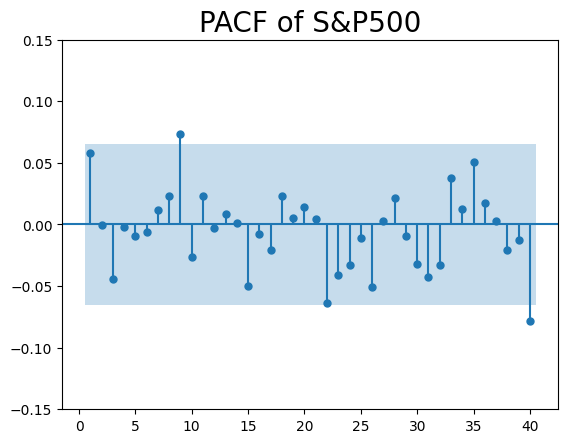

In [146]:
sgt.plot_pacf(df['SPX(i1)'], zero = False, lags = 40)
plt.title("PACF of S&P500", size = 20)
plt.ylim(-0.15,0.15)
#As seen before, the 9th lag is the most significant lag in the PACF

### Comparing models to determine if MA(9) is the best fit

In [152]:
#Looking at all AR(p) models from 1 to 9
ma_1 = ARIMA(df['SPX(i1)'], order=(0,0,1))
results_ma_1 = ma_1.fit()
print(results_ma_1.summary()) 

ma_2 = ARIMA(df['SPX(i1)'], order=(0,0,2))
results_ma_2 = ma_2.fit()
print(results_ma_2.summary())

ma_3 = ARIMA(df['SPX(i1)'], order=(0,0,3))
results_ma_3 = ma_3.fit()
print(results_ma_3.summary())

ma_4 = ARIMA(df['SPX(i1)'], order=(0,0,4))
results_ma_4 = ma_4.fit()
print(results_ma_4.summary())

ma_5 = ARIMA(df['SPX(i1)'], order=(0,0,5))
results_ma_5 = ma_5.fit()
print(results_ma_5.summary())

ma_6 = ARIMA(df['SPX(i1)'], order=(0,0,6))
results_ma_6 = ma_6.fit()
print(results_ma_6.summary())

ma_7 = ARIMA(df['SPX(i1)'], order=(0,0,7))
results_ma_7 = ma_7.fit()
print(results_ma_7.summary())

ma_8 = ARIMA(df['SPX(i1)'], order=(0,0,8))
results_ma_8 = ma_8.fit()
print(results_ma_8.summary())

ma_9 = ARIMA(df['SPX(i1)'], order=(0,0,9))
results_ma_9 = ma_9.fit()
print(results_ma_9.summary())

#Additional lag to ensure 9th lag is the most optimal
ma_10 = ARIMA(df['SPX(i1)'], order=(0,0,10))
results_ma_10 = ma_10.fit()
print(results_ma_10.summary()) 

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python

                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -4724.233
Date:                Wed, 12 Mar 2025   AIC                           9454.467
Time:                        23:42:35   BIC                           9468.894
Sample:                             0   HQIC                          9459.976
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3866      1.612      0.860      0.390      -1.772       4.546
ma.L1          0.0571      0.027      2.083      0.037       0.003       0.111
sigma2      1980.0622     70.896     27.929      0.0

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -4723.359
Date:                Wed, 12 Mar 2025   AIC                           9456.719
Time:                        23:42:35   BIC                           9480.764
Sample:                             0   HQIC                          9465.902
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3873      1.586      0.875      0.382      -1.721       4.496
ma.L1          0.0574      0.028      2.071      0.038       0.003       0.112
ma.L2          0.0046      0.028      0.166      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -4723.346
Date:                Wed, 12 Mar 2025   AIC                           9458.692
Time:                        23:42:35   BIC                           9487.546
Sample:                             0   HQIC                          9469.711
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3874      1.604      0.865      0.387      -1.757       4.531
ma.L1          0.0575      0.028      2.078      0.038       0.003       0.112
ma.L2          0.0046      0.028      0.166      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -4723.316
Date:                Wed, 12 Mar 2025   AIC                           9460.633
Time:                        23:42:36   BIC                           9494.296
Sample:                             0   HQIC                          9473.488
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3875      1.607      0.863      0.388      -1.762       4.537
ma.L1          0.0576      0.028      2.073      0.038       0.003       0.112
ma.L2          0.0051      0.028      0.181      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -4723.316
Date:                Wed, 12 Mar 2025   AIC                           9462.633
Time:                        23:42:36   BIC                           9501.105
Sample:                             0   HQIC                          9477.325
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3875      1.635      0.849      0.396      -1.816       4.591
ma.L1          0.0576      0.028      2.060      0.039       0.003       0.112
ma.L2          0.0051      0.028      0.181      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -4723.298
Date:                Wed, 12 Mar 2025   AIC                           9464.595
Time:                        23:42:37   BIC                           9507.877
Sample:                             0   HQIC                          9481.124
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3872      1.648      0.842      0.400      -1.842       4.617
ma.L1          0.0573      0.028      2.038      0.042       0.002       0.112
ma.L2          0.0040      0.028      0.142      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -4723.125
Date:                Wed, 12 Mar 2025   AIC                           9466.251
Time:                        23:42:39   BIC                           9514.341
Sample:                             0   HQIC                          9484.616
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3868      1.676      0.827      0.408      -1.898       4.672
ma.L1          0.0543      0.028      1.934      0.053      -0.001       0.109
ma.L2          0.0044      0.028      0.156      0.8

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -4720.422
Date:                Wed, 12 Mar 2025   AIC                           9462.844
Time:                        23:42:40   BIC                           9515.744
Sample:                             0   HQIC                          9483.046
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3837      1.794      0.771      0.441      -2.133       4.900
ma.L1          0.0590      0.027      2.183      0.029       0.006       0.112
ma.L2          0.0027      0.028      0.096      0.9

/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ivan/Documents/Data Science Projects/Portfolio_Forecast/arima/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                SPX(i1)   No. Observations:                  906
Model:                ARIMA(0, 0, 10)   Log Likelihood               -4720.224
Date:                Wed, 12 Mar 2025   AIC                           9464.448
Time:                        23:42:41   BIC                           9522.156
Sample:                             0   HQIC                          9486.486
                                - 906                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3873      1.769      0.784      0.433      -2.080       4.855
ma.L1          0.0581      0.028      2.098      0.036       0.004       0.112
ma.L2          0.0015      0.028      0.052      0.9

In [149]:
#LLR Test for the above MA models
print(f"p-value = {LLR_test(ma_1, ma_2)}")
print(f"p-value = {LLR_test(ma_2, ma_3)}")
print(f"p-value = {LLR_test(ma_3, ma_4)}")
print(f"p-value = {LLR_test(ma_4, ma_5)}")
print(f"p-value = {LLR_test(ma_5, ma_6)}")
print(f"p-value = {LLR_test(ma_6, ma_7)}")
print(f"p-value = {LLR_test(ma_7, ma_8)}")
print(f"p-value = {LLR_test(ma_8, ma_9)}")
print(f"p-value = {LLR_test(ma_9, ma_10)}") 
#Again, we see that only the 9th lag is significant

p-value = 0.813
p-value = 0.193
p-value = 0.869
p-value = 0.808
p-value = 0.986
p-value = 0.847
p-value = 0.557
p-value = 0.02
p-value = 0.529


In [153]:
print(f"MA(1) AIC: {results_ma_1.aic}, BIC: {results_ma_1.bic}")
print(f"MA(2) AIC: {results_ma_2.aic}, BIC: {results_ma_2.bic}")
print(f"MA(3) AIC: {results_ma_3.aic}, BIC: {results_ma_3.bic}")
print(f"MA(4) AIC: {results_ma_4.aic}, BIC: {results_ma_4.bic}")
print(f"MA(5) AIC: {results_ma_5.aic}, BIC: {results_ma_5.bic}")
print(f"MA(6) AIC: {results_ma_6.aic}, BIC: {results_ma_6.bic}")
print(f"MA(7) AIC: {results_ma_7.aic}, BIC: {results_ma_7.bic}")
print(f"MA(8) AIC: {results_ma_8.aic}, BIC: {results_ma_8.bic}")
print(f"MA(9) AIC: {results_ma_9.aic}, BIC: {results_ma_9.bic}")
print(f"MA(10) AIC: {results_ma_10.aic}, BIC: {results_ma_10.bic}")

MA(1) AIC: 9454.466886408602, BIC: 9468.89400432673
MA(2) AIC: 9456.410695550514, BIC: 9475.646852774686
MA(3) AIC: 9456.71899442575, BIC: 9480.764190955964
MA(4) AIC: 9458.691903707806, BIC: 9487.546139544063
MA(5) AIC: 9460.63285361058, BIC: 9494.29612875288
MA(6) AIC: 9462.632526217496, BIC: 9501.10484066584
MA(7) AIC: 9464.595171524074, BIC: 9507.87652527846
MA(8) AIC: 9466.250813484188, BIC: 9514.341206544617
MA(9) AIC: 9462.84433205197, BIC: 9515.743764418441
MA(10) AIC: 9464.447742875203, BIC: 9522.156214547718


In [ ]:
if results_ma_9.aic < results_ma_8.aic: 
    print("AIC suggests that MA(9) is the optimal model")
else:
    print("AIC suggests that MA(8) is the optimal model")

if results_ma_9.bic < results_ma_8.bic:
    print("BIC suggests that MA(9) is the optimal model")
else:
    print("BIC suggests that MA(8) is the optimal model")

#Again, we reach the same conclusion as before, and so we will proceed with the 9th lag as our starting model for the ARIMA

AIC suggests that MA(9) is the optimal model
BIC suggests that MA(8) is the optimal model
